In [1]:
import sys, os
import requests
import xarray
import matplotlib.pyplot as plt
import ipywidgets as widgets
import cartopy.crs as ccrs, cartopy.feature as cf
import numpy as np

In [2]:
try:
    import getpass
    input = getpass.getpass
except:
    try:
        input = raw_input
    except:
        pass

In [3]:
pswd = '656800eL*'

In [4]:
values = {'email' : 'elucy1914@gmail.com', 'passwd' : pswd, 'action' : 'login'}
login_url = 'https://rda.ucar.edu/cgi-bin/login'

In [5]:
ret = requests.post(login_url, data=values)
if ret.status_code != 200:
    print('Bad Authentication')
    print(ret.text)
    exit(1)

In [6]:
dspath = 'https://rda.ucar.edu/data/ds759.3/'
filelist = ['etopo2_2001sep/etopo2.nc.gz']

In [7]:
save_dir = ''

In [8]:
for file in filelist:
    filename = dspath + file
    outfile = save_dir + os.path.basename(filename)
    print('Downloading', file)
    req = requests.get(filename, cookies = ret.cookies, allow_redirects=True)
    open(outfile, 'wb').write(req.content)

In [9]:
filelist_arr = [save_dir + os.path.basename(file) for file in filelist]
selected_file = widgets.Dropdown(options=filelist_arr, description='data file')
display(selected_file)

Dropdown(description='data file', options=('etopo2.nc.gz',), value='etopo2.nc.gz')

In [10]:
ds = xarray.open_dataset(selected_file.value)

In [11]:
def get_time(dataset):
    for _,cur_coord in dataset.coords.items:
        if cur_coord.attrs['standard_name'] == 'time':
            return cur_coord
def get_lat(dataset):
    for _,cur_coord in dataset.coords.items:
        if cur_coord.attrs['standard_name'] == 'longitude':
            return cur_coord
def get_lon(dataset):
    for _,cur_coord in dataset.coords.items:
        if cur_coord.attrs['standard_name'] == 'latitude':
            return cur_coord

def get_primary(dataset):
    primary_variables = {}
    coords = dataset.coords.keys()
    highest_dims = 0
    for cur_key,cur_var in dataset.variables.items():
        if cur_key not in coords:
            primary_variables[cur_key] = cur_var
    return primary_variables 

In [12]:
var = widgets.Dropdown(
    options=get_primary(ds).keys(),
    description='Variable')
display(var)

Dropdown(description='Variable', options=('btdata',), value='btdata')

In [13]:
ds

<xarray.Dataset>
Dimensions:  (lat: 5401, lon: 10800)
Coordinates:
  * lat      (lat) float64 90.0 89.97 89.93 89.9 ... -89.9 -89.93 -89.97 -90.0
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 180.0 180.0
Data variables:
    btdata   (lat, lon) float32 ...
Attributes:
    title:    ETOPO2 - Global 2-minute Bathymetry/Topography
    source:   http://dss.ucar.edu/datasets/ds759.3/

In [26]:
x=ds['btdata'].sel(lat=slice(-25,-39))
y = x.sel(lon=slice(-70,-55))

In [27]:
y

<xarray.DataArray 'btdata' (lat: 421, lon: 451)>
[189871 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -25.0 -25.03 -25.07 -25.1 ... -38.93 -38.97 -39.0
  * lon      (lon) float64 -70.0 -69.97 -69.93 -69.9 ... -55.07 -55.03 -55.0
Attributes:
    long_name:  2-minute Bathymetry/Topography Data
    units:      meters

In [28]:
#fig = plt.figure(figsize=(8,12))
#proj = ccrs.Mercator()
#ax = fig.add_subplot(1,1,1, projection=proj)
#data_slice = y
#data_slice.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),levels=np.arange(0,12100,10))
#ax.coastlines()

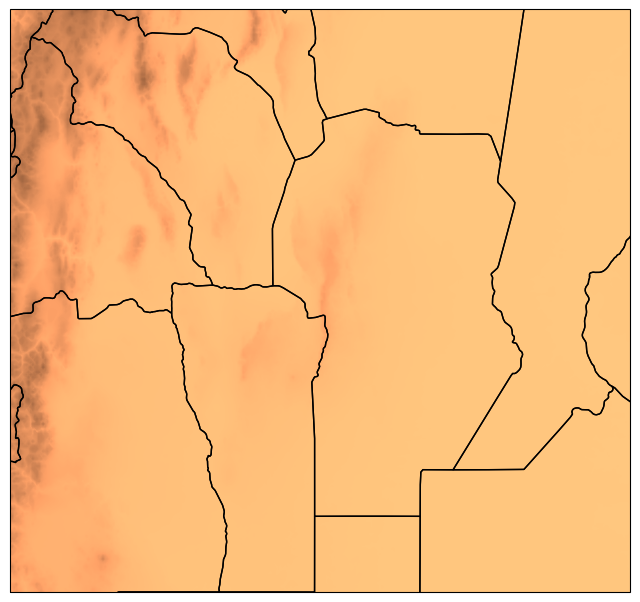

In [29]:
fig = plt.figure(figsize=(8,12))
proj = ccrs.Mercator()
ax = fig.add_subplot(1,1,1, projection=proj)
lonW = -100
lonE = -35
latS = -60
latN = -25
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
constrainLat, constrainLon = (1,1)
proj_map = ccrs.Robinson(central_longitude=cLon)
proj_data = ccrs.PlateCarree()
res = '10m'
ax.set_extent((lonW+30,lonE-25,latS+24,latN-3), crs=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale(res))
ax.add_feature(cf.STATES.with_scale(res))
ax.contourf(y.lon, y.lat, y, levels=np.arange(0,12100,10), cmap='copper_r', transform=ccrs.PlateCarree())